# Preprocessing the data

In [1]:
import pandas as pd
import json

# Load business data
business_df = pd.read_json('yelp_dataset\yelp_academic_dataset_business.json', lines=True)

# Filter for  OPEN ONLY businesses in California
business_ca_open = business_df[(business_df['state'] == 'CA') & (business_df['is_open'] == 1)]

# Display filtered data
print(f"Number of open businesses in California: {business_ca_open.shape[0]}")
print(business_ca_open.head())

Number of open businesses in California: 4065
                business_id                             name  \
26   noByYNtDLQAra9ccqxdfDw                              H&M   
85   IDtLPgUrqorrpqSLdfMhZQ             Helena Avenue Bakery   
91   nUqrF-h9S7myCcvNDecOvw             Iron Horse Auto Body   
120  bYjnX_J1bHZob10DoSFkqQ      Tinkle Belle Diaper Service   
141  SZU9c8V2GuREDN5KgyHFJw  Santa Barbara Shellfish Company   

                   address           city state postal_code   latitude  \
26        827-833 State St  Santa Barbara    CA       93101  34.420209   
85   131 Anacapa St, Ste C  Santa Barbara    CA       93101  34.414445   
91          825 Cacique St  Santa Barbara    CA       93103  34.419620   
120                         Santa Barbara    CA       93101  34.420334   
141      230 Stearns Wharf  Santa Barbara    CA       93101  34.408715   

      longitude  stars  review_count  is_open  \
26  -119.700460    3.0            24        1   
85  -119.690672    4.0    

In [2]:
# Merge Open California Businesses with Reviews using business_id as key

# Load review data
review_df = pd.read_json('yelp_dataset\yelp_academic_dataset_review.json', lines=True)

# Merge only reviews for open businesses in California
review_ca_open = review_df.merge(business_ca_open[['business_id', 'name', 'categories']], on='business_id')

# Display filtered reviews
print(f"Number of reviews for open businesses in California: {review_ca_open.shape[0]}")
print(review_ca_open.head())

Number of reviews for open businesses in California: 287807
                review_id                 user_id             business_id  \
0  ZKvDG2sBvHVdF5oBNUOpAQ  wSTuiTk-sKNdcFyprzZAjg  B5XSoSG3SfvQGtKEGQ1tSQ   
1  9ag-bC-521T1i3IypXr4Ug  sx_cqxyWRUoOIoy_AXmLdQ  B5XSoSG3SfvQGtKEGQ1tSQ   
2  80p5xO3dbpd80T6vPTL8DQ  D7ct4p7uUk5t4LFSjVnO4A  B5XSoSG3SfvQGtKEGQ1tSQ   
3  RScubg9WIp165432dQfVHQ  r9VkVP_4d2_KMHA9ZN2c6w  B5XSoSG3SfvQGtKEGQ1tSQ   
4  _JsMDKDQJ8uc6logHxA0-w  s0l9vVweCwvudj5TNGMl6w  B5XSoSG3SfvQGtKEGQ1tSQ   

   stars  useful  funny  cool  \
0      3       1      1     0   
1      4       1      0     0   
2      5       0      0     0   
3      5      14      9    13   
4      5       1      0     0   

                                                text                date  \
0  This easter instead of going to Lopez Lake we ... 2016-03-30 22:46:33   
1  I work with a college group that does camping ... 2013-09-07 21:16:36   
2  My SO and I love exploring new trails and so i.

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Convert the textual reviews into a numerical representation using TF-IDF (Term Frequency-Inverse Document Frequency)
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)  # Limit to 5000 most important terms
review_tfidf = tfidf.fit_transform(review_ca_open['text'])

print(f"TF-IDF Matrix Shape: {review_tfidf.shape}")  # High-dimensional representation

# Apply Dimentionality Reduction using Principal Component Analysis (PCA)
pca = PCA(n_components=50)  # Reduce to 50 components
reduced_reviews = pca.fit_transform(review_tfidf.toarray())

print(f"Reduced Dimensions Shape: {reduced_reviews.shape}")  # Lower-dimensional representation

TF-IDF Matrix Shape: (287807, 5000)
Reduced Dimensions Shape: (287807, 50)


# Clustering

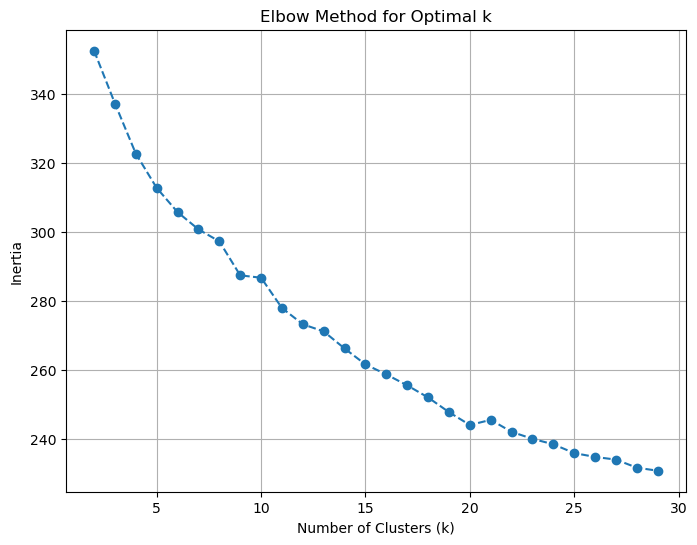

In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Associate reduced review features with businesses
business_features = pd.DataFrame(reduced_reviews, columns=[f'PC{i+1}' for i in range(reduced_reviews.shape[1])])
business_features['business_id'] = review_ca_open['business_id'].values

# Drop duplicates for business ids and keep only first instance
business_features = business_features.drop_duplicates(subset='business_id', keep='first')

# Determine the best number of clusters using Elbow Method
inertia = []
k_values = range(2, 30)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(business_features.drop(columns=['business_id']))
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid()
plt.show()

In [23]:
# Apply K-Means with the chosen number of clusters based on the Elbow Curve
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
business_features['cluster'] = kmeans.fit_predict(business_features.drop(columns=['business_id']))

# Merge cluster labels back to business data
business_clusters = business_features[['business_id', 'cluster']].merge(
    business_ca_open[['business_id', 'name', 'categories']], on='business_id'
)

# Display sample results
print(business_clusters.head())

              business_id  cluster                             name  \
0  B5XSoSG3SfvQGtKEGQ1tSQ        2       Los Padres National Forest   
1  gebiRewfieSdtt17PTW6Zg        2  Hibachi Steak House & Sushi Bar   
2  vC2qm1y3Au5czBtbhc-DNw        7                       Sushi Teri   
3  bbEXAEFr4RYHLlZ-HFssTA        8  The Original Habit Burger Grill   
4  IDtLPgUrqorrpqSLdfMhZQ        3             Helena Avenue Bakery   

                                          categories  
0                                 Parks, Active Life  
1     Steakhouses, Sushi Bars, Restaurants, Japanese  
2                            Restaurants, Sushi Bars  
3                    Fast Food, Burgers, Restaurants  
4  Food, Restaurants, Salad, Coffee & Tea, Breakf...  


# Output

In [24]:
# Merge user reviews with clusters to determine user interactions
user_cluster_data = review_ca_open.merge(
    business_clusters[['business_id', 'cluster']], on='business_id'
)

# Assign users to their most-interacted cluster
user_cluster_pref = user_cluster_data.groupby(['user_id', 'cluster']).size().reset_index(name='review_count')

# Find the cluster with the highest review count for each user
user_pref_cluster = user_cluster_pref.loc[
    user_cluster_pref.groupby('user_id')['review_count'].idxmax()
].rename(columns={'cluster': 'preferred_cluster'})

# Recommend businesses from the preferred cluster
def recommend_businesses(user_id, num_recommendations=5):
    # Check if the user exists in the preference data
    if user_id not in user_pref_cluster['user_id'].values:
        return f"User {user_id} has no interactions recorded."

    # Get the user's preferred cluster
    preferred_cluster = user_pref_cluster[user_pref_cluster['user_id'] == user_id]['preferred_cluster'].values[0]
    
    # Get all businesses in this cluster
    cluster_businesses = business_clusters[business_clusters['cluster'] == preferred_cluster]
    
    # Exclude businesses the user has already reviewed
    reviewed_businesses = user_cluster_data[user_cluster_data['user_id'] == user_id]['business_id'].unique()
    recommendations = cluster_businesses[~cluster_businesses['business_id'].isin(reviewed_businesses)]
    
    # Select top businesses for recommendation (or fewer if less available)
    return recommendations[['name', 'categories']].sample(n=min(num_recommendations, len(recommendations)))

In [25]:
# Example: Generate recommendations for a user
user_id_example = user_cluster_data['user_id'].iloc[0]  # recommend for the first user in the dataset
recommendations = recommend_businesses(user_id_example, num_recommendations=5)
print(f"Recommendations for User {user_id_example}:\n", recommendations)

Recommendations for User wSTuiTk-sKNdcFyprzZAjg:
                                  name  \
1     Hibachi Steak House & Sushi Bar   
1651           Montecito Union School   
736         Che Argentinian Empanadas   
454          Yogurtland Santa Barbara   
1612                          Outpost   

                                             categories  
1        Steakhouses, Sushi Bars, Restaurants, Japanese  
1651  Elementary Schools, Middle Schools & High Scho...  
736   Latin American, Restaurants, Argentine, Empana...  
454                     Ice Cream & Frozen Yogurt, Food  
1612  Restaurants, American (New), Bars, Nightlife, ...  


In [26]:
#Find insights for users and business owners using Association Rules
from mlxtend.frequent_patterns import apriori, association_rules

# Prepare data for Apriori (one-hot encoding)
user_cluster_matrix = user_cluster_data.pivot_table(
    index='user_id', columns='cluster', aggfunc='size', fill_value=0
)
user_cluster_matrix = user_cluster_matrix.applymap(lambda x: 1 if x > 0 else 0)

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(user_cluster_matrix, min_support=0.03, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, user_cluster_matrix, metric="lift", min_threshold=1.0)

# Sort rules by lift and display
rules_sorted = rules.sort_values(by="lift", ascending=False)
print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

  antecedents consequents   support  confidence      lift
6      (9, 2)         (8)  0.031568    0.431834  2.138368
7         (8)      (9, 2)  0.031568    0.156318  2.138368
8         (9)      (8, 2)  0.031568    0.164223  1.835489
5      (8, 2)         (9)  0.031568    0.352827  1.835489
4      (8, 9)         (2)  0.031568    0.773645  1.392791


C:\Users\dodda\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [19]:
# Insights Interpretation
# About 3.15% of all users in the our filtered dataset reviewed businesses in clusters {9, 2} and {8}
# 43.1% of users who reviewed businesses in clusters {9, 2} also reviewed businesses in {8}
# Users reviewing {9, 2} are 2.13 times more likely to review {8} compared to random chance.